<a href="https://colab.research.google.com/github/hatimnaitlho/ml-sklearn/blob/master/ExtraTreeClassifier_for_breast_cancer_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extra Tree Classifier for Breast Cancer Diagnosis

In this notebook we will build, assess and tune ExtraTreeClassifier with 100% recall, and up to 95% precision. The classifier will be trained and assessed based on the `Wisconsin Breast Cancer diagnosis dataset`. 

This dataset is computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

### Why recall?
Imagine that we built a model that gives an accuracy_score of 98%. The score may seem good, but what if accuracy is not pertinent in our case.
So, let's dive on the meaning of accuracy to unterstand better the notion of this performance metric.
Accuracy will answer to the follwing question: 
- how often is the classifier correct? 
Thus, we can say that our model is correct 98% of time. So, for 1000 patients, the model is able to predict correctly 980 of the cases, which can be considered as a very good performance.
Now, let's imagine that the model fails in classifing 10 malignant tumors. The accuracy is still 98%, but 10 sick patients were sent home without treatment, which will represent  a catastroph!

This is why, accuracy is not considered as the good performance metric in our context (prediction if a tumor is malignant or benign). 

We need instead, `Precision` and `Recall` metrics which are more relevant.

- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

- Recall is The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

`Recall is more important than precision in a breast cancer predictor`


In [0]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns


# to make this notebook's output reproducible across runs
np.random.seed(42)

### Loading the cancer dataset

In [0]:
from sklearn import datasets

cancer_dataset = datasets.load_breast_cancer()

# Exploring the cancer dataset

In [37]:
cancer_dataset.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [38]:
print(cancer_dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

# Exploratory Data Analysis & Features Selection

Let's build the cancer breast dataframe based on `'data'` and `'feature_names'`, which is more convenient.

In [39]:
df = pd.DataFrame(data=cancer_dataset.data, columns=list(cancer_dataset.feature_names))
df['target']= cancer_dataset.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [40]:
print('Data Set Characteristics:')
print('The Number of Instances is: {}'.format(df.shape[0]))
print('The Number of Attributes is: {}'.format(df.shape[1]-1))

Data Set Characteristics:
The Number of Instances is: 569
The Number of Attributes is: 30


In [41]:
# Fill empty and NaNs values with NaN
df = df.fillna(np.nan)

# Check for Null values
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

### Features selection
Let's first plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable `target`.

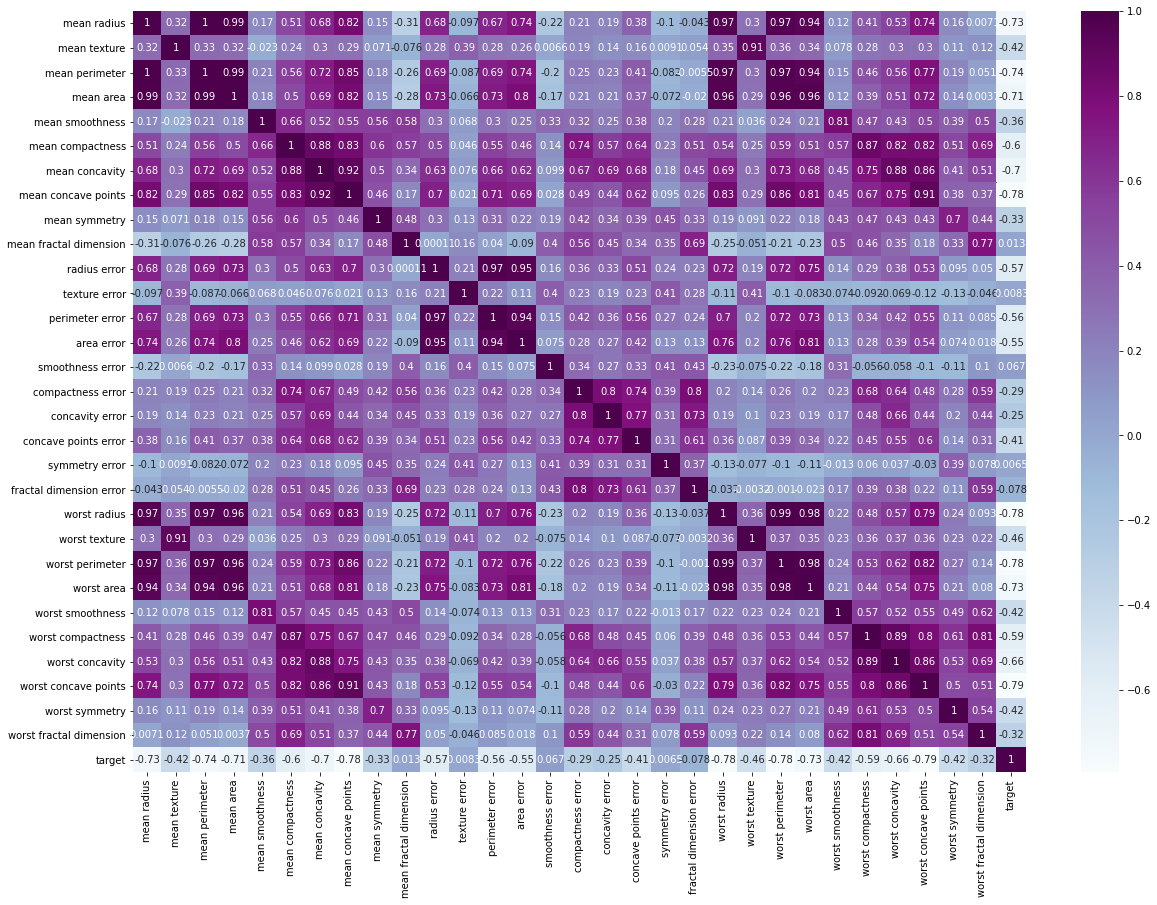

In [43]:
# Correlation matrix
cor = df.corr()

plt.figure(figsize = (20,14))

g = sns.heatmap(df.corr(), annot=True, cmap = 'BuPu')

#### Relevant features
We will choose a treshold to filter features based on their correlation with the target.

In [9]:
#Correlation with the output variable
treshold= 0.3
cor_target = abs(cor['target'])
#Selecting moderate to highly correlated features
relevant_features = cor_target[cor_target>=treshold]
print('The number of highly relevant features is: {}'.format(relevant_features.shape[0]))
relevant_features

The number of highly relevant features is: 24


mean radius                0.730029
mean texture               0.415185
mean perimeter             0.742636
mean area                  0.708984
mean smoothness            0.358560
mean compactness           0.596534
mean concavity             0.696360
mean concave points        0.776614
mean symmetry              0.330499
radius error               0.567134
perimeter error            0.556141
area error                 0.548236
concave points error       0.408042
worst radius               0.776454
worst texture              0.456903
worst perimeter            0.782914
worst area                 0.733825
worst smoothness           0.421465
worst compactness          0.590998
worst concavity            0.659610
worst concave points       0.793566
worst symmetry             0.416294
worst fractal dimension    0.323872
target                     1.000000
Name: target, dtype: float64

In [10]:
features_to_drop = cor_target[cor_target<treshold]
features_to_drop

mean fractal dimension     0.012838
texture error              0.008303
smoothness error           0.067016
compactness error          0.292999
concavity error            0.253730
symmetry error             0.006522
fractal dimension error    0.077972
Name: target, dtype: float64

Now let's drop the features considered as having low correlation with the target. `mean fractal dimension`, `texture error`, `smoothness error`, `compactness error`, `concavity error`, `symmetry error`, `fractal dimension error`

In [0]:
dfc= df.copy()
dfc.drop(columns=['mean fractal dimension', 'texture error', 'smoothness error', 'compactness error', 
                  'concavity error', 'symmetry error', 'fractal dimension error'], inplace= True)

In [0]:
X= dfc.drop(columns=['target'])
y= dfc['target']

#### Spliting and scaling data

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's normalize the model using `StandardScaler`

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

# Ensemble Methods

In [16]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

classifiers= [RandomForestClassifier(), AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier() ]

l1, l2, l3, l4 =([] for i in range(4))

metrics_dict = {}


for clf in classifiers:
  clf.fit(X_train, y_train)
  clf.predict(X_test)
  name= clf.__class__.__name__
  l1.append(name)
  metrics_dict['model']= l1
  l2.append(recall_score(y_test, clf.predict(X_test)))
  metrics_dict['recall_score']= l2
  l3.append(precision_score(y_test, clf.predict(X_test)))
  metrics_dict['precision_score'] = l3
  l4.append(accuracy_score(y_test, clf.predict(X_test)))
  metrics_dict['accuracy_score'] = l4


df = pd.DataFrame(metrics_dict)
df

,model,recall_score,precision_score,accuracy_score
0,RandomForestClassifier,0.985915,0.958904,0.964912
1,AdaBoostClassifier,0.985915,0.958904,0.964912
2,BaggingClassifier,0.957746,0.957746,0.947368
3,ExtraTreesClassifier,0.985915,0.972222,0.973684


`ExtraTreesClassifier` performs well campared to the other  classifiers. However, as we will see that the recall of `ExtraTreesClassifier` doesn't improve and stay at the same value, even when we improve the tuning of its hyperparameters. 

Probably, we may have some features that have a significant impact and prevent the model from performing well.

In this case, we will have to reiterate to the step 'features selection' and focus on features that matters the most for the model. 

# ExtraTreesClassifier

### Tuning ExtraTreeClassifier Parameters

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

scorer= make_scorer(recall_score)

n_estimators = [15, 20, 30, 40, 50]
max_depth = [25, 30, 35, 40, 45]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [2, 5, 10]  

parameter_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,  
                  'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}


clf_grid = GridSearchCV(estimator=ExtraTreesClassifier(), 
                    param_grid=parameter_grid,
                    scoring= scorer,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf_grid.fit(X_train, y_train)

optimised_extratree = clf_grid.best_estimator_
print(clf_grid.best_params_)

{'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 15}


In [0]:
y_predET= optimised_extratree.predict(X_test)

In [19]:
# Model Recall: what percentage of malignant tumors are labelled as such?
print("Recall:", recall_score(y_test, y_predET))
# Model Precision: what percentage of malignant tumors are labeled as such?
print("Precision:", precision_score(y_test, y_predET))
# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_predET))

Recall: 1.0
Precision: 0.9594594594594594
Accuracy: 0.9736842105263158


Tuning hyperparameters using GridSearchCV method improved the recall (recall_score=1), but the precision actually decreased.  We can keep the model as such, but in realworld projects, we have to iterate until reaching the "optimal" model. 

`Performing more advanced filtering features using the “feature_importances_” attribute of the Extra tree will be quite helpful and ultimately will boost the performance of the final model.`

## Filtering features using the `feature_importances_` attribute

In [20]:
optimised_extratree.feature_importances_

array([0.03647601, 0.04475976, 0.00741991, 0.12875369, 0.01042409,
       0.0170821 , 0.04673362, 0.03531103, 0.00483117, 0.00875131,
       0.03254705, 0.03353835, 0.01455653, 0.11246311, 0.02851511,
       0.066031  , 0.1421476 , 0.0111513 , 0.06430852, 0.08484456,
       0.0611571 , 0.00468548, 0.00351161])

In [0]:
keys= list(X.columns)
values= list(optimised_extratree.feature_importances_)
new_dict = dict(zip(keys, values))

In [23]:
lf=[]
for (k,v) in new_dict.items(): 
  if v>0.01:
    lf.append(k)
print(lf)

['mean radius', 'mean texture', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'perimeter error', 'area error', 'concave points error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points']


In [24]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,radius error,perimeter error,area error,concave points error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,8.589,153.40,0.01587,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,3.398,74.08,0.01340,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,4.585,94.03,0.02058,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,3.445,27.23,0.01867,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,5.438,94.44,0.01885,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [25]:
Xr=X.copy()
Xr= Xr[lf]
Xr.head()

,mean radius,mean texture,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,perimeter error,area error,concave points error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points
0,17.99,10.38,1001.0,0.11840,0.27760,0.3001,0.14710,8.589,153.40,0.01587,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654
1,20.57,17.77,1326.0,0.08474,0.07864,0.0869,0.07017,3.398,74.08,0.01340,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860
2,19.69,21.25,1203.0,0.10960,0.15990,0.1974,0.12790,4.585,94.03,0.02058,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430
3,11.42,20.38,386.1,0.14250,0.28390,0.2414,0.10520,3.445,27.23,0.01867,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575
4,20.29,14.34,1297.0,0.10030,0.13280,0.1980,0.10430,5.438,94.44,0.01885,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625


## Spliting and normalizing the data

In [0]:
Xr_train, Xr_test, yr_train, yr_test= train_test_split(Xr, y, test_size=0.2,random_state=42)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
Xr_train = scaler.fit_transform(Xr_train)  
Xr_test = scaler.transform(Xr_test)

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

scorer= make_scorer(recall_score)

n_estimators = [15, 20, 30, 40, 50]
max_depth = [25, 30, 35, 40, 45]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [2, 5, 10] 

parameter_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,  
                  'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}


clf_grid = GridSearchCV(estimator=ExtraTreesClassifier(), 
                    param_grid=parameter_grid,
                    scoring= scorer,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf_grid.fit(Xr_train, yr_train)

optimised_extratreeclf = clf_grid.best_estimator_
print(clf_grid.best_params_)


{'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 20}


In [0]:
prediction=optimised_extratreeclf.predict(Xr_test)

In [30]:
# Model Recall: what percentage of malignant tumors are labelled as such?
print("Recall:", recall_score(yr_test, prediction))
# Model Precision: what percentage of malignant tumors are labeled as such?
print("Precision:", precision_score(yr_test, prediction))

print("Accuracy:", accuracy_score(yr_test, prediction))

Recall: 1.0
Precision: 0.9726027397260274
Accuracy: 0.9824561403508771


Well, now we have improved our model with a recall equal to 1.0 by using advanced filtering techniques.


In [31]:
from sklearn.metrics import confusion_matrix


col= ['predicted "Malignant"', 'predicted "Benign"']
rws= ['Malignant', 'Benign']
mc= confusion_matrix(yr_test, prediction, labels=[1,0])
df_mc_ET=pd.DataFrame(data= mc, index=rws, columns=col)
df_mc_ET

,"predicted ""Malignant""","predicted ""Benign"""
Malignant,71,0
Benign,2,41
